## Setup

In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import brentq
import pandas as pd
import time

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import (
    EffectiveAreaTable2D,
    EnergyDispersion2D,
    EnergyDependentMultiGaussPSF,
    Background3D,
)
from gammapy.maps import WcsGeom, MapAxis, WcsNDMap
from gammapy.spectrum import models
from gammapy.image.models import SkyPointSource
from gammapy.cube.models import SkyModel, BackgroundModel
from gammapy.cube import MapDataset, MapEvaluator, PSFKernel
from gammapy.cube import make_map_exposure_true_energy, make_map_background_irf
from gammapy.utils.fitting import Fit

from gammapy.astro.darkmatter import PrimaryFlux
from gammapy.utils.fitting import Parameter, Parameters

## Load IRFs

In [3]:
def get_irfs():
    """Load CTA IRFs"""
    filename = "$CTADATA/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
    psf = EnergyDependentMultiGaussPSF.read(
        filename, hdu="POINT SPREAD FUNCTION"
    )
    aeff = EffectiveAreaTable2D.read(filename, hdu="EFFECTIVE AREA")
    edisp = EnergyDispersion2D.read(filename, hdu="ENERGY DISPERSION")
    bkg = Background3D.read(filename, hdu="BACKGROUND")
    return dict(psf=psf, aeff=aeff, edisp=edisp, bkg=bkg)
irfs = get_irfs()

## Derive ancillary IRF maps 

**Define map geometry**

In [4]:
GLON = 96.34 * u.Unit("deg")
GLAT = -60.19 * u.Unit("deg")
src_pos = SkyCoord(GLON, GLAT, frame="galactic")
emin = 0.03 
emax = 100
unit = "TeV"
lg_emin = np.log10(emin)
lg_emax = np.log10(emax)
ENERGY_BINS = 31

In [5]:
axis = MapAxis.from_edges(
    np.logspace(lg_emin, lg_emax, ENERGY_BINS),
    unit=unit,
    name="energy",
    interp="log",
)
geom = WcsGeom.create(
    skydir=src_pos, binsz=0.02, width=(2, 2), coordsys="GAL", axes=[axis]
)

**Declare observation values**

In [6]:
pointing = src_pos
livetime = 50 * u.hour
offset = 2 * u.deg

**Build maps**

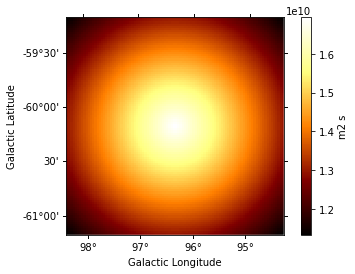

In [7]:
exposure = make_map_exposure_true_energy(
    pointing=pointing, livetime=livetime, aeff=irfs["aeff"], geom=geom
)
exposure.slice_by_idx({"energy": 3}).plot(add_cbar=True);

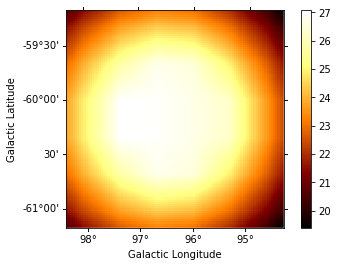

In [8]:
background = make_map_background_irf(
    pointing=pointing, ontime=livetime, bkg=irfs["bkg"], geom=geom
)
background.slice_by_idx({"energy": 3}).plot(add_cbar=True);

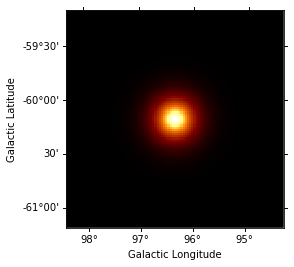

In [9]:
psf = irfs["psf"].to_energy_dependent_table_psf(theta=offset)
psf_kernel = PSFKernel.from_table_psf(psf, geom, max_radius=1 * u.deg)
psf_kernel.psf_kernel_map.sum_over_axes().plot(stretch="log");

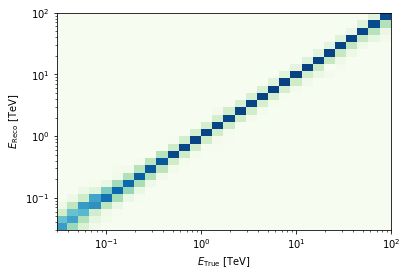

In [10]:
edisp = irfs["edisp"].to_energy_dispersion(
    offset=offset, e_reco=axis.edges * axis.unit, e_true=axis.edges * axis.unit
)
edisp.plot_matrix();

## Build model

**Declare constants and parameters for our DM model**

In [11]:
JFAC = 3.41e19 * u.Unit("GeV2 cm-5") # <--- point source / may be also a 2D map
mDM = 5000*u.Unit("GeV")
channel = "b"

**Define Spectral User Model**

https://docs.gammapy.org/0.10/notebooks/spectrum_models.html#User-defined-model

In [12]:
#redshift = 0.5
#dominguez = Absorption.read_builtin('dominguez').table_model(redshift)
#flux_model = DMAnnihilModel(mass=500*u.MeV, channel="b", EBL=dominguez)

In [13]:
class DMAnnihilModel(models.SpectralModel):
    def __init__(self, mass, channel, scale=1, jfactor=1, EBL=None):
        self.parameters = Parameters(
            [
                Parameter("scale", scale),
            ]
        )
        self.jfactor = jfactor
        self.mass = mass
        self.table_model = PrimaryFlux(mass, channel=channel).table_model
        
    def evaluate(self, energy, scale):
        flux = (
            scale 
            * self.jfactor
            * 3e-26 * u.Unit("cm3 s-1") # THERMAL_RELIC_CROSS_SECTION 
            * self.table_model.evaluate(energy=energy, norm=1)
#            * self.EBL.evaluate(energy=energy, norm=1)
            / self.mass
            / self.mass
            / (8 * np.pi)
        )
        return flux

**Define 3D Sky Model**

In [14]:
flux_model = DMAnnihilModel(
    mass=mDM, channel=channel, scale=1, jfactor=JFAC
)
spatial_model = SkyPointSource(lat_0=GLAT, lon_0=GLON)  # <--- because JFactor is a number
sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=flux_model
)

## Evaluate and display our 3D model simulation

In [15]:
background_model = BackgroundModel(background)

In [16]:
simulate_dataset = MapDataset(
    model=sky_model,
    exposure=exposure,
    psf=psf_kernel,
    edisp=edisp,
    background_model=background_model,
)

In [17]:
npred_map = simulate_dataset.npred()

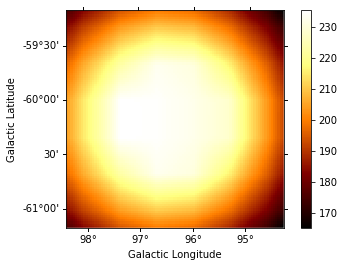

In [18]:
npred_map.sum_over_axes().plot(add_cbar=True);

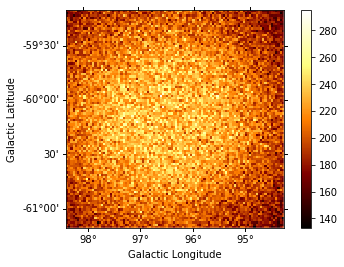

In [19]:
rng = np.random.RandomState(seed=int(time.time()))
counts = rng.poisson(npred_map.data)
counts_map = WcsNDMap(geom, counts)
counts_map.sum_over_axes().plot(add_cbar=True);

## Fit model loop

In [20]:
def ts_diff(x):
    result.parameters["scale"].value = x
    stat = fit.total_stat(result.parameters)
    return (stat - stat_best_fit) - 2.71

**Fit for different mDM and channels**

In [21]:
#We do not want to fit the background in this case, so we will freeze the parameters
background_model.parameters["norm"].value = 1.0
background_model.parameters["norm"].frozen = True
background_model.parameters["tilt"].frozen = True

In [22]:
%%time
massval_list = [70, 200, 500, 5000, 10000, 50000, 100000]
channel_list = ["b"] 
NumberOfRuns = 9

# data structure
columns = ["run", "mass", "sigma_v"]
df = pd.DataFrame(columns=columns)

# loop
for run in range(NumberOfRuns)[0:1]:

    rng = np.random.RandomState(seed=1+int(time.time()))
    counts = rng.poisson(npred_map.data)
    counts_map = WcsNDMap(geom, counts)
    
    print('#-----------------------------------------')
    print("RUN", run+1)
    for ch in channel_list:
        for mass in massval_list:
            print("mass", mass)
            
            # ------- TUNE IN MODEL IN MASS/CHANNEL RANGE
            spectral_model = DMAnnihilModel(
                            mass = mass * u.GeV,
                            channel= ch,
                            scale = 1,
                            jfactor = JFAC,
                            )
            model3D = SkyModel(
                            spatial_model=spatial_model, spectral_model=spectral_model
                            )
            
            # ------- FIT TO FIXED MODEL
            model3D.parameters['lat_0'].frozen=True
            model3D.parameters['lon_0'].frozen=True

            dataset = MapDataset(
                model=model3D,
                counts=counts_map,
                exposure=exposure,
                background_model=background_model,
                psf=psf_kernel,
                edisp=edisp
            )
            
            fit = Fit(dataset)
            fit.datasets.parameters.apply_autoscale = False
            result = fit.run()

            stat_best_fit = result.total_stat
            scale_best = result.parameters["scale"].value
            print(scale_best)

            max_scan = scale_best + 4*result.parameters.error("scale")*result.parameters["scale"].scale
            scale_f = brentq(ts_diff, scale_best, max_scan, maxiter=100, rtol=1e-5)
            sigma_v = scale_f * 3e-26 # THERMAL_RELIC_CROSS_SECTION
            print(scale_f)
            
            df = df.append(
                {"run": run, "mass": mass, "sigma_v": sigma_v},
                ignore_index=True,
            )
            print("sigma_v", sigma_v)

#-----------------------------------------
RUN 1
mass 70
101.21755019802968
493.0797474549704
sigma_v 1.4792392423649114e-23
mass 200
12.183706615757892
96.31179653239319
sigma_v 2.8893538959717956e-24
mass 500
16.550879556440623
59.984570434090045
sigma_v 1.7995371130227016e-24
mass 5000
8.488604412510833
49.81529012043585
sigma_v 1.4944587036130754e-24
mass 10000
15.86891087993083
65.94717184080072
sigma_v 1.9784151552240218e-24
mass 50000
92.75869050255397
208.17770649141684
sigma_v 6.2453311947425055e-24
mass 100000
134.61479187982138
337.7336683335093
sigma_v 1.0132010050005279e-23
CPU times: user 28.9 s, sys: 1.38 s, total: 30.3 s
Wall time: 33.9 s


In [23]:
#counts_map.plot_interactive(add_cbar=True);

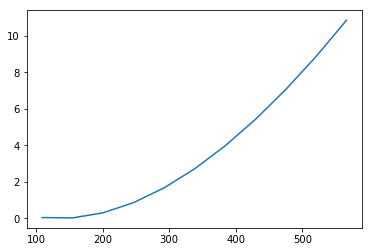

In [24]:
#p = fit.likelihood_profile(parameter="scale", reoptimize=True)
p = fit.likelihood_profile(parameter="scale")
plt.plot(p["values"], p["likelihood"] - result.total_stat)

In [25]:
model3D.parameters.to_table()

name,value,error,unit,min,max,frozen
str5,float64,float64,str3,float64,float64,bool
lon_0,9.634e+01,nan,deg,-1.800e+02,1.800e+02,True
lat_0,-6.019e+01,nan,deg,-9.000e+01,9.000e+01,True
scale,3.377e+02,nan,,nan,nan,False


## Plot obtained results

In [26]:
df[["run"]] = df[["run"]].astype(int)
df[["mass"]] = df[["mass"]].astype(int)

stats = df.groupby(["mass"]).mean()
stats_std = df.groupby(["mass"]).std()
stats.drop(["run"], axis=1, inplace=True)
stats_std.drop(["run"], axis=1, inplace=True)
#stats_std.columns = ["std_sigma_v"]

#stats = pd.merge(stats, stats_std, left_index=True, right_index=True)
stats

,sigma_v
mass,
70,1.479239e-23
200,2.889354e-24
500,1.799537e-24
5000,1.494459e-24
10000,1.978415e-24
50000,6.245331e-24
100000,1.013201e-23


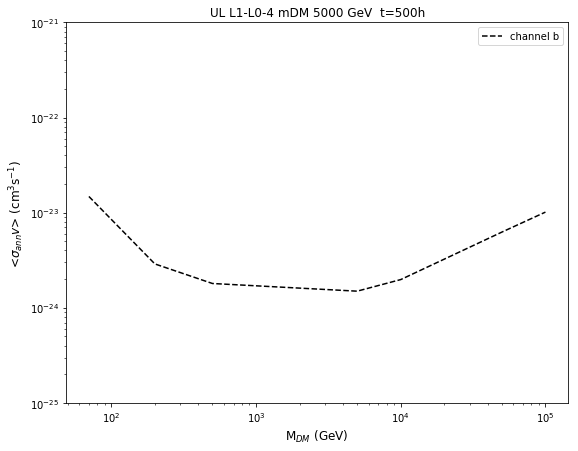

In [27]:
fig, ax1 = plt.subplots(1, figsize=(9, 7))

ax1.loglog(
    stats.index.values,
    stats["sigma_v"],
    color="k",
    ls="--",
    label='channel b'
)

ax1.set_xlabel("M$_{DM}$ (GeV)", fontsize=12)
ax1.set_ylabel(r"<$\sigma_{ann}v$> (cm$^3$s$^{-1}$)", fontsize=12)
ax1.set_ylim(1e-25, 1e-21)
ax1.set_title("UL L1-L0-4 mDM 5000 GeV  t=500h")
ax1.legend()